In [3]:
import pandas as pd 
import os
os.chdir('/home/spankaew/Git/astrologics')
import astrologics as le
import seaborn as sns
import matplotlib.pyplot as plt

# Load model path into logic_ensemble object

In [4]:
model_path = '/home/spankaew/Git/astrologics/models/toy_reprogramming_1/'
model = le.LogicEnsemble(model_path, project_name = 'toy_reprogramming')
model.create_simulation()

Simulation object created


# Calculate attractors from the model cohorts
In this part of the script, we calculate attractors from cohorts of model, and compared using clustermap

In [5]:
model.create_attractor()
model.attractor.get_attractors()
model.attractor.attractors_df

Attractor object created


100%|██████████| 8/8 [00:01<00:00,  4.39it/s]


Concatenate results into matrix


100%|██████████| 8/8 [00:00<00:00, 562.45it/s]

Attractors calculation completed



/home/spankaew/Git/astrologics/astrologics/model_attractors.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.attractors_df = model_logic.fillna(0)


,bn3,bn4,bn7,bn5,bn0,bn2,bn6,bn1
1110001111000010,1,0,0,0,0,0,1,0
0000001110000010,0,1,0,0,0,0,0,0
1110000001011101,0,0,1,0,1,0,0,0
1111110001111101,0,0,0,1,0,0,0,0
0001110000111101,0,0,0,0,1,0,0,1
0001111110100010,0,0,0,0,0,1,1,0


This shows that actually the two differences between the model 1 and two comes from the fact that you missed one value position when computing the attractor. I'll have to revise the script for doing this better.

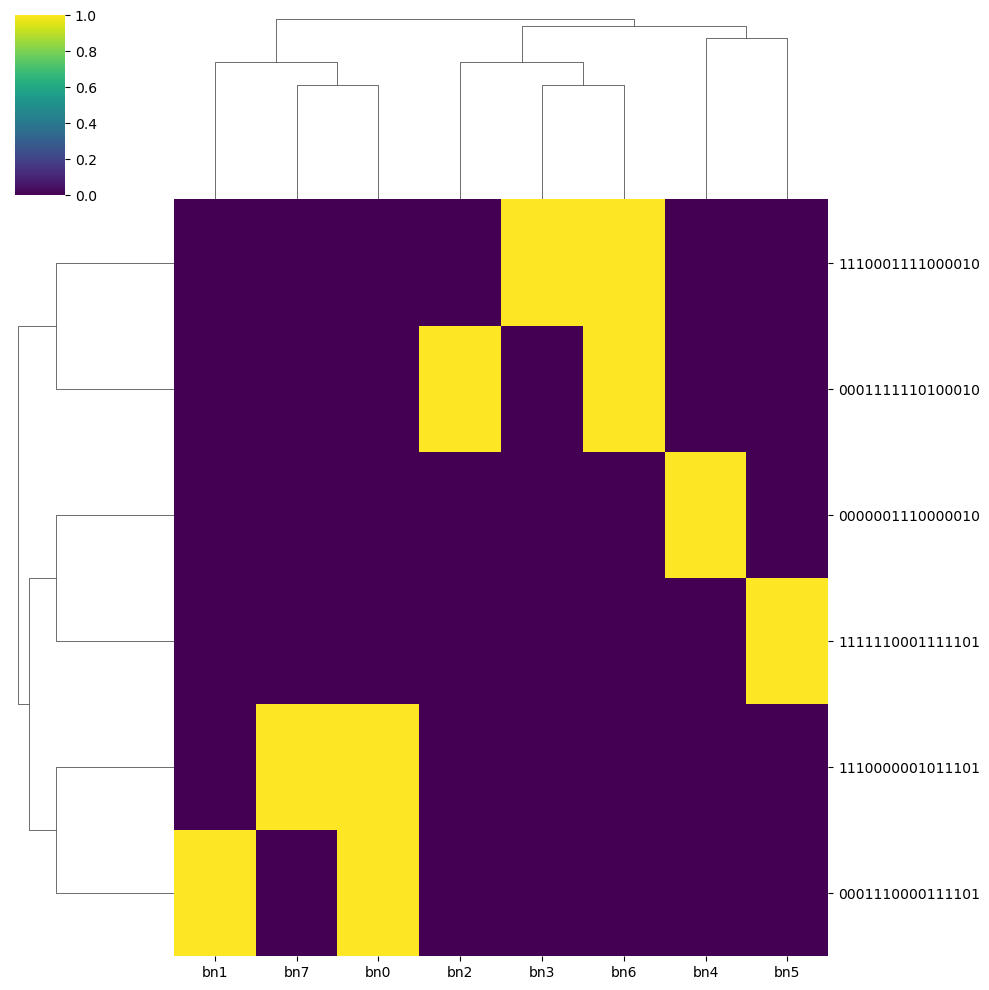

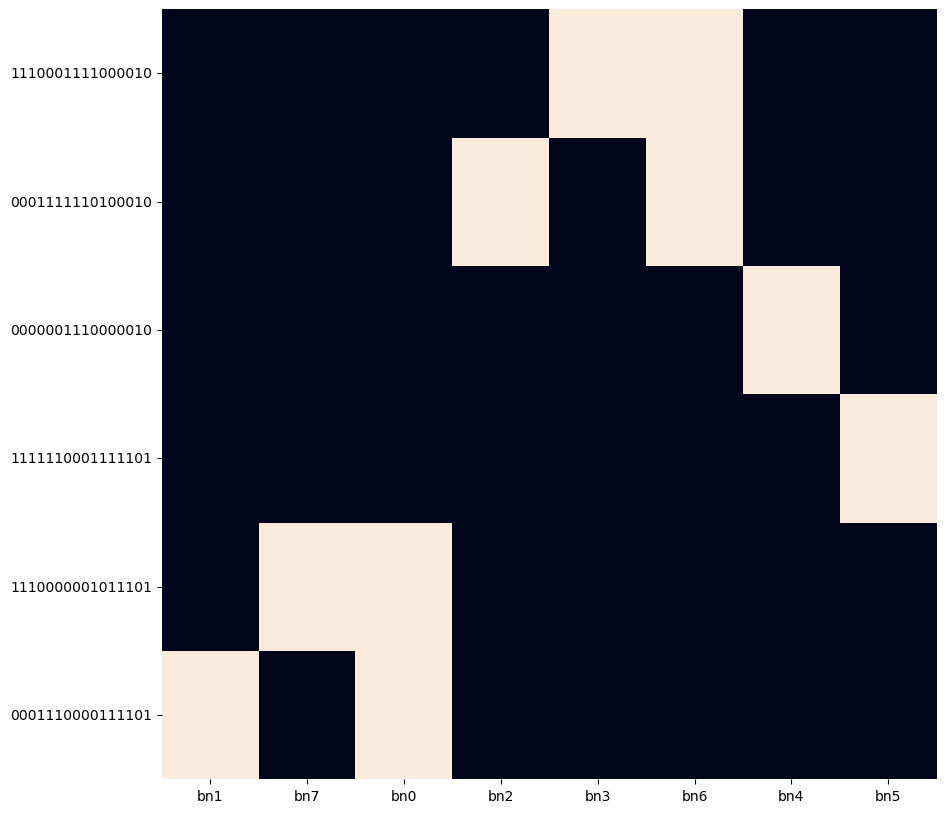

In [6]:
# Create the clustermap
clustermap = sns.clustermap(model.attractor.attractors_df, 
                            cmap='viridis', vmax=1, vmin=0, figsize=(10,10))

# Get the row and column order from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind

# Reorder the dataframe
reordered_df = model.attractor.attractors_df.iloc[row_order, col_order]

# Plot the heatmap with the reordered dataframe without color bar
plt.figure(figsize=(10,10))
sns.heatmap(reordered_df, 
            #cmap='viridis', 
            vmax=1, vmin=0, cbar=False)
#plt.savefig('/home/spankaew/Git/BooleanBenchmark/figures/toy_reprogramming_AttractorHeatmap.pdf')
plt.show()
plt.close()

From `logic_ensemble` object -> you can define simulation parameters and initial condition of the simulation directly. The simulation gives the node activity at each simulation time that is stored in the object called `.simulation.simulation_df`

# Create simulation trajectory from the simulation
When we perform the simulation, the result of the timestep node activity can be visualized using dimension reduction method such as `pca`.

In [7]:
model.simulation.update_parameters(max_time = 10)
model.simulation.run_simulation()

Start simulation


100%|██████████| 8/8 [00:01<00:00,  7.55it/s]

Simulation completed


Trajectory object created


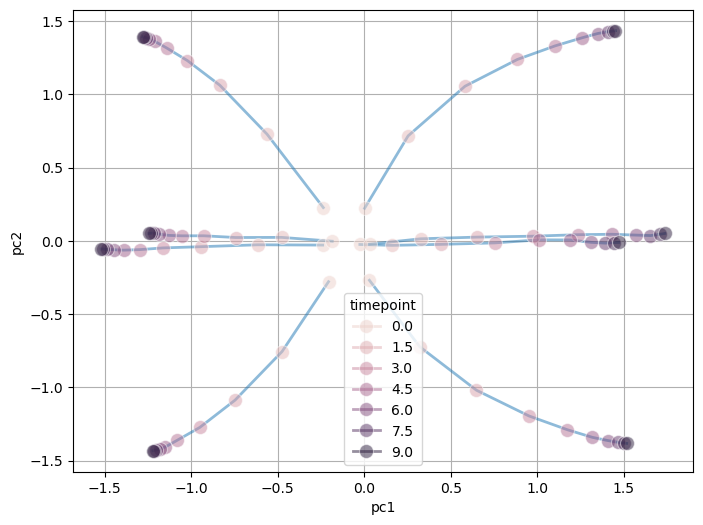

In [8]:
model.create_trajectory()
model.trajectory.pca_trajectory()
model.trajectory.plot_trajectory(color = 'timepoint', show_legend=True)

From the visualization, we can then try to group together models with simular simulation activity via clustering. 

In `logic_ensemble`, we utilize the package called `tslearn` - a toolkit to perform analysis on time series data. 

The timeseries clustering method included in this toolkit includes : 

- euclidean

- dynamic time warping (dtw) 

- softdtw.

The calculated clustering will be embeded into the trajectory matrix

In [9]:
import numpy as np
# Setup the 
pca_df = model.trajectory.pca_df
pca_df.model_id = pca_df.model_id.astype('category')
model_name = pca_df.model_id.cat.categories

simulation_df = model.simulation.simulation_df
simulation_df.model_id = simulation_df.model_id.astype('category')
node_list = simulation_df.columns.drop(['timepoint','model_id'])

model_original_all = {}
for i in model_name:
    model_original = simulation_df.loc[simulation_df.model_id == i,node_list].values
    model_original_all[i] = np.array(model_original)
pca_all_trajectory = np.array(list(model_original_all.values()))

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fals

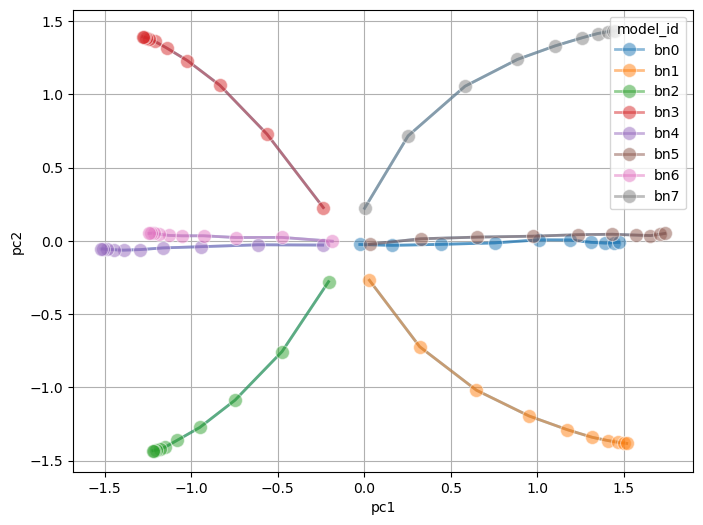

In [10]:
model.trajectory.plot_trajectory(color = 'model_id', show_legend=True)

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


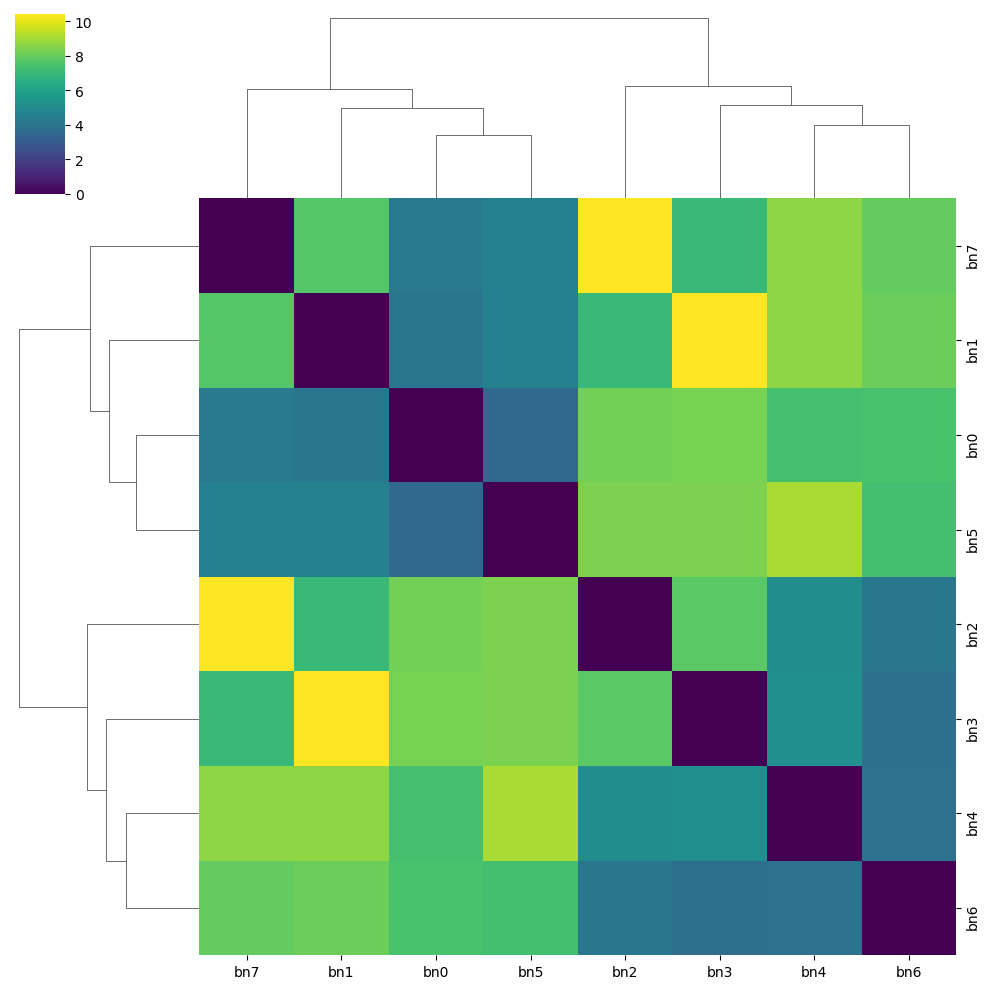

In [12]:
from tslearn.metrics import dtw

# Initialize an empty distance matrix
num_trajectories = len(pca_all_trajectory)
distance_matrix = np.zeros((num_trajectories, num_trajectories))

# Calculate DTW distance for each pair of trajectories
for i in range(num_trajectories):
    for j in range(num_trajectories):
        distance_matrix[i, j] = dtw(pca_all_trajectory[i], pca_all_trajectory[j])

# Display the distance matrix
distance_matrix = pd.DataFrame(distance_matrix, index=model_name, columns=model_name)
sns.clustermap(distance_matrix, cmap='viridis', figsize=(10,10))

/tmp/ipykernel_9014/1421893242.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


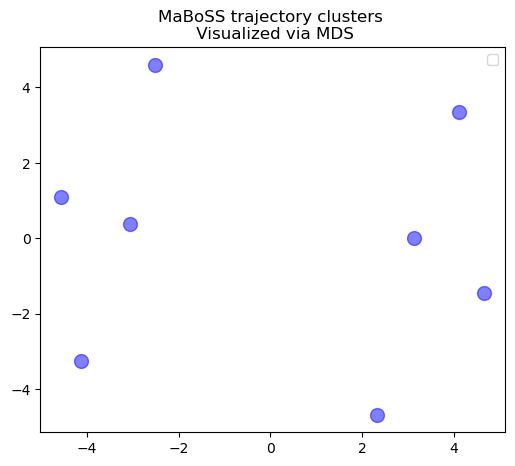

In [30]:
# Visualize clusters with MDS
from sklearn.manifold import MDS

# Visualize clusters with MDS
#distance_matrix = model.succession_diagram.distance_matrix
mds = MDS(dissimilarity='precomputed', random_state=12345)
coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], c='blue', alpha=0.5, s = 100)
plt.legend()
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/toy_reprogramming_trajMDS.pdf')

plt.show()

plt.close()

Succession diagram object created
Calculating Succession Diagrams


100%|██████████| 8/8 [00:00<00:00, 22.97it/s]


Succession Diagrams calculated


100%|██████████| 8/8 [00:00<00:00, 158.63it/s]


Creating SD networks


100%|██████████| 8/8 [00:00<00:00, 318.03it/s]


SD networks created


  0%|          | 0/8 [00:00<?, ?it/s]/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/netrd/utilities/graph.py:74: RuntimeWarning: Coercing directed graph to undirected.
  warnings.warn("Coercing directed graph to undirected.", RuntimeWarning)
100%|██████████| 8/8 [00:00<00:00, 68.64it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


SD networks distance calculated


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


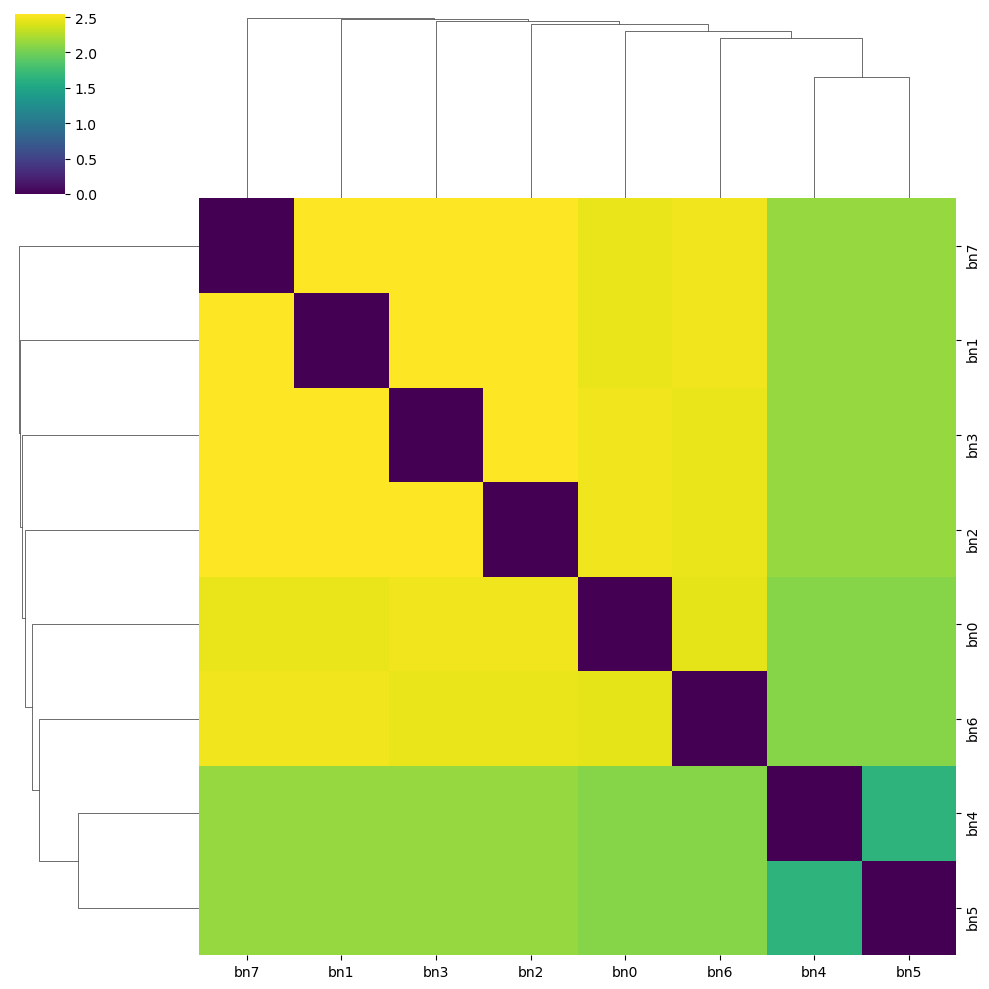

In [19]:
model.create_succession_diagram()
model.succession_diagram.calculate_succession_diagram()
model.succession_diagram.calculate_sd_states()
model.succession_diagram.create_sd_networks()
model.succession_diagram.calculate_sdnet_distance()
sns.clustermap(model.succession_diagram.distance_matrix, cmap='viridis')

/tmp/ipykernel_9014/1696512091.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


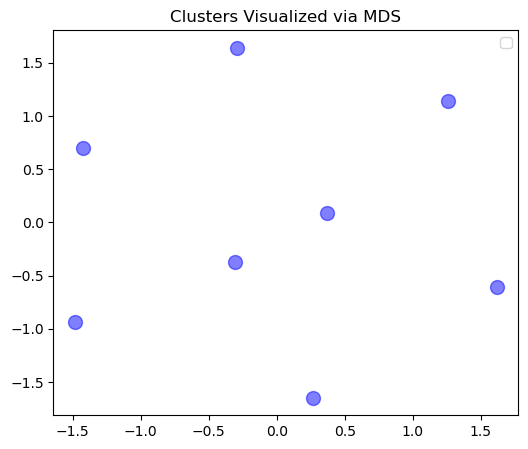

In [29]:
# Visualize clusters with MDS
distance_matrix_2 = model.succession_diagram.distance_matrix
mds = MDS(dissimilarity='precomputed', random_state=12345)
coords = mds.fit_transform(distance_matrix_2)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], c='blue', alpha=0.5, s = 100)
plt.legend()
plt.title('Clusters Visualized via MDS')
plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/toy_reprogramming_sdMDS.pdf')

plt.show()

plt.close()

In [21]:
distance_matrix = distance_matrix.loc[model_name, model_name]
distances_1 = distance_matrix.where(np.triu(np.ones(distance_matrix.shape ,dtype = bool), k=1)).stack().reset_index()
distances_1['combined'] = distances_1['level_0'] + "_" + distances_1['level_1']
distances_1.set_index('combined', inplace=True)
distances_1.drop(columns=['level_0', 'level_1'], inplace=True)
distances_1.columns = ['traj_distance']

In [22]:
distance_matrix_2 = distance_matrix_2.loc[model_name, model_name]
distances_2 = distance_matrix_2.where(np.triu(np.ones(distance_matrix_2.shape ,dtype = bool), k=1)).stack().reset_index()
distances_2['combined'] = distances_2['level_0'] + "_" + distances_2['level_1']
distances_2.set_index('combined', inplace=True)
distances_2.drop(columns=['level_0', 'level_1'], inplace=True)
distances_2.columns = ['sd_distance']

Correlation between the two distance matrices: 0.11451788444595279
P-value: 0.5617403154108223


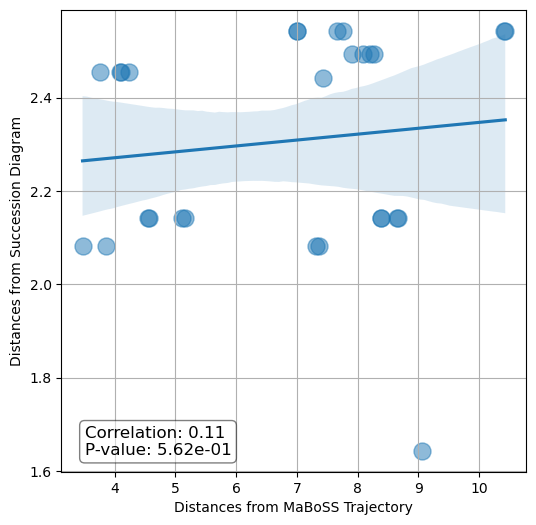

In [47]:
from scipy.stats import pearsonr

# Extract the upper triangular parts of the distance matrices (excluding the diagonal)
distance_matrix = distance_matrix.loc[model_name, model_name]
distances_1 = distance_matrix.where(np.triu(np.ones(distance_matrix.shape, dtype='bool'), k=1)).stack()

distance_matrix_2 = distance_matrix_2.loc[model_name, model_name]
distances_2 = distance_matrix_2.where(np.triu(np.ones(distance_matrix_2.shape, dtype='bool'), k=1)).stack()

# Compute the correlation and p-value
correlation, p_value = pearsonr(distances_1.values, distances_2.values)

# Print the correlation and p-value
print(f"Correlation between the two distance matrices: {correlation}")
print(f"P-value: {p_value}")

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(6, 6))
sns.regplot(x=distances_1.values, y=distances_2.values, scatter_kws={'s': 150, 'alpha': 0.5})
plt.xlabel("Distances from MaBoSS Trajectory")
plt.ylabel("Distances from Succession Diagram")
plt.grid(True)

# Add a box label with correlation and p-value
plt.text(
    0.05, 0.1, 
    f"Correlation: {correlation:.2f}\nP-value: {p_value:.2e}", 
    transform=plt.gca().transAxes, 
    fontsize=12, 
    verticalalignment='top', 
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
)

plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/toy_reprogramming_distCorr.pdf')

plt.show()

plt.close()

# Create logic function matrix
In this part of the script, we load models' logic function into a matrix. This matrix can then be transformed into a Disjunctive Normal Form (DNF) which allow us to identify clause of components that can activate each node. 

In [8]:
model.create_logic()
model.logic.model_logic

Loading models logics


100%|██████████| 8/8 [00:00<00:00, 156.33it/s]


Concatenate results into matrix


100%|██████████| 8/8 [00:00<00:00, 1238.31it/s]

Logic object created


,bn3,bn4,bn7,bn5,bn0,bn2,bn6,bn1
G1,(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1)
G2,(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1)
G3,(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1)
G4,(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2)
G5,(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2)
G6,(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2)
G7,(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6)
G8,(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6)
G9,(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6)
TF1,(!TF2) | (TF3),(!TF2 & TF3),(!TF2) | (TF3),(!TF2) | (TF3),(!TF2 & TF3),(!TF2 & TF3),(!TF2) | (TF3),(!TF2 & TF3)


Flatten models logic clauses


100%|██████████| 8/8 [00:00<00:00, 96420.78it/s]


Concatenate results into matrix


100%|██████████| 8/8 [00:00<00:00, 1146.65it/s]


Flattend logic clause created


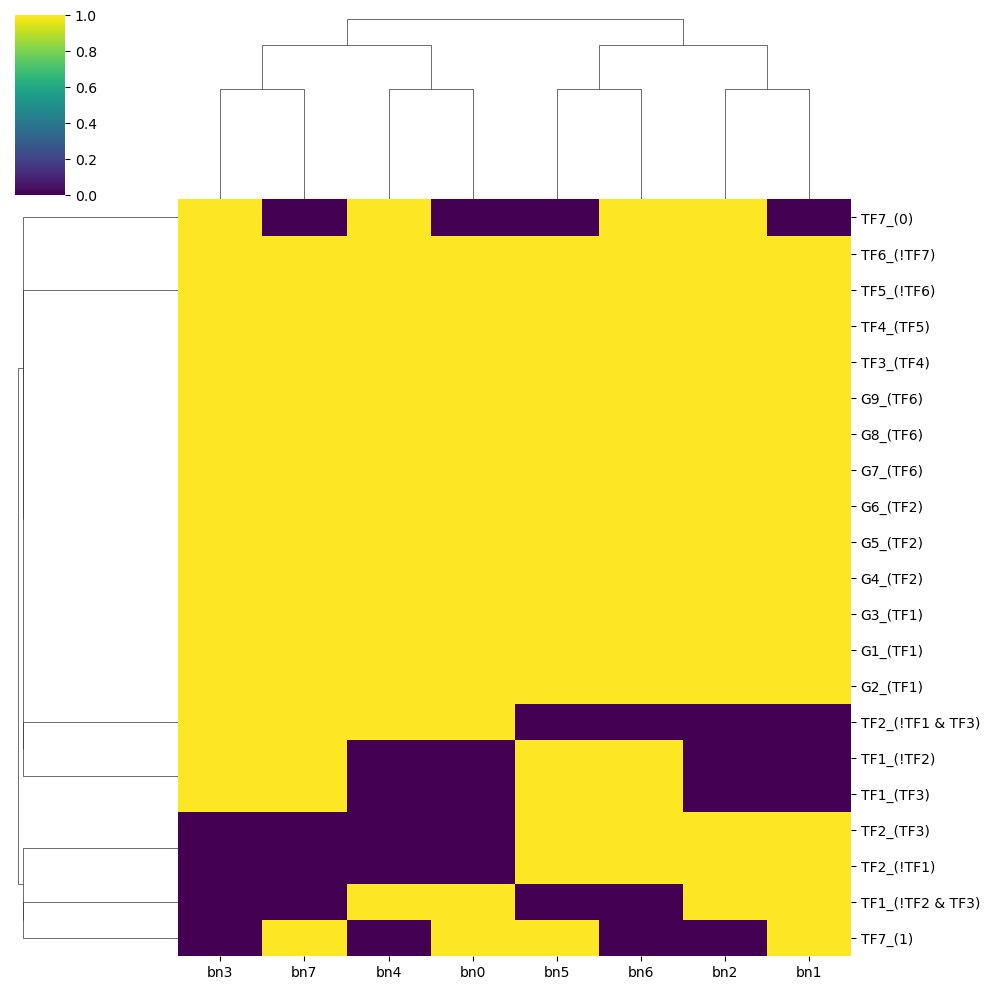

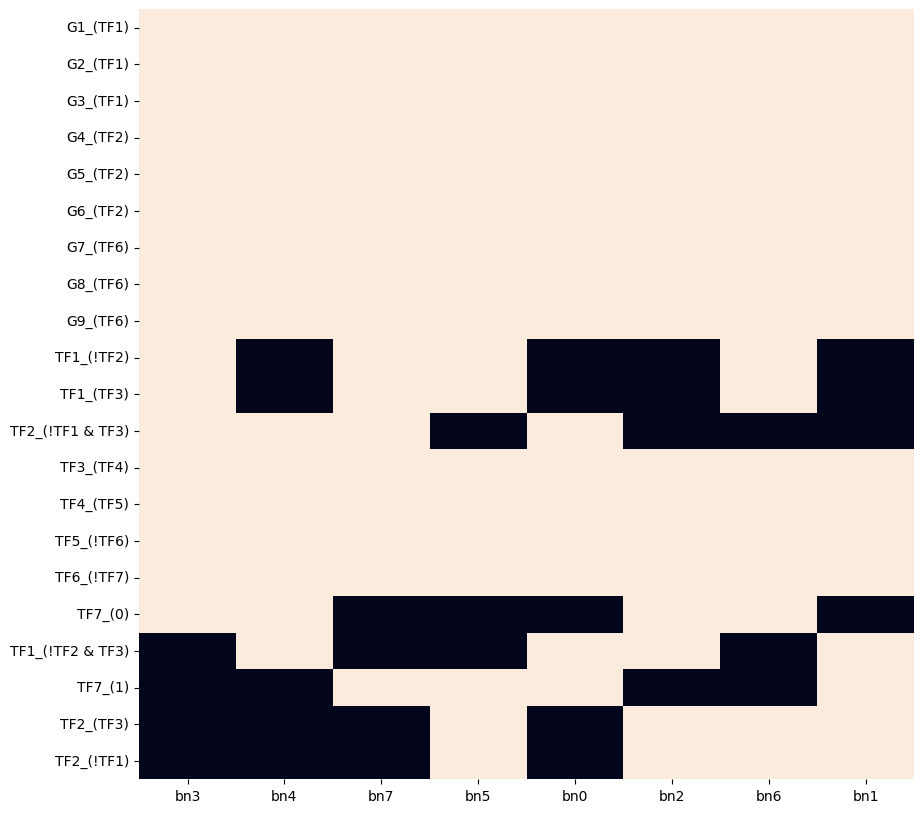

In [13]:
model.logic.create_flattend_logic_clause()
# Create the clustermap
clustermap = sns.clustermap(model.logic.logic_clause_flattend, 
                            cmap='viridis', vmax=1, vmin=0, figsize=(10,10))

# Get the row and column order from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind

# Reorder the dataframe
reordered_df = model.logic.logic_clause_flattend.iloc[row_order, col_order]
# Plot the heatmap with the reordered dataframe without color bar
plt.figure(figsize=(10,10))
sns.heatmap(model.logic.logic_clause_flattend, vmax=1, vmin=0, cbar=False)
plt.savefig('/home/spankaew/Git/BooleanBenchmark/figures/toy_reprogramming_Logic.pdf')
plt.show()
plt.close()

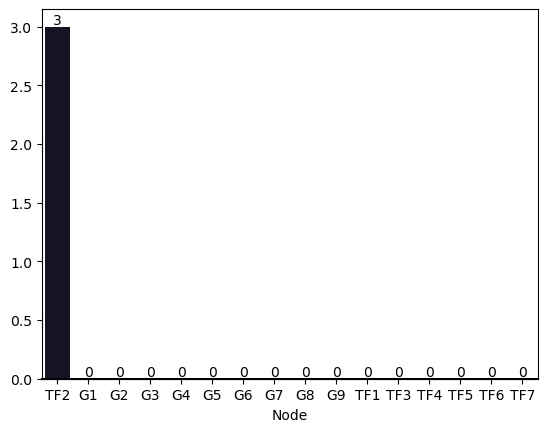

In [14]:
test = model.logic.logic_clause_flattend.copy()
test_dif = test['bn0'] - test['bn1']

# Split the index into two parts
split_index = test_dif.index.str.split('_', expand=True)
split_df = split_index.to_frame(index=False)
split_df['value'] = test_dif.values

# Pivot the DataFrame to create the matrix
matrix = split_df.pivot(index=0, columns= 1, values='value')

# Display the matrix
plot_value = matrix.abs().sum(axis = 1).sort_values(ascending = False)


plot = sns.barplot(x=plot_value.index, y=plot_value.values, palette="rocket")
plot.axhline(0, color="k", clip_on=False)
plot.set_xlabel("Node")
plot.bar_label(plot.containers[0], fontsize=10)
plt.show()

NameError: name 'var_logic_clust' is not defined

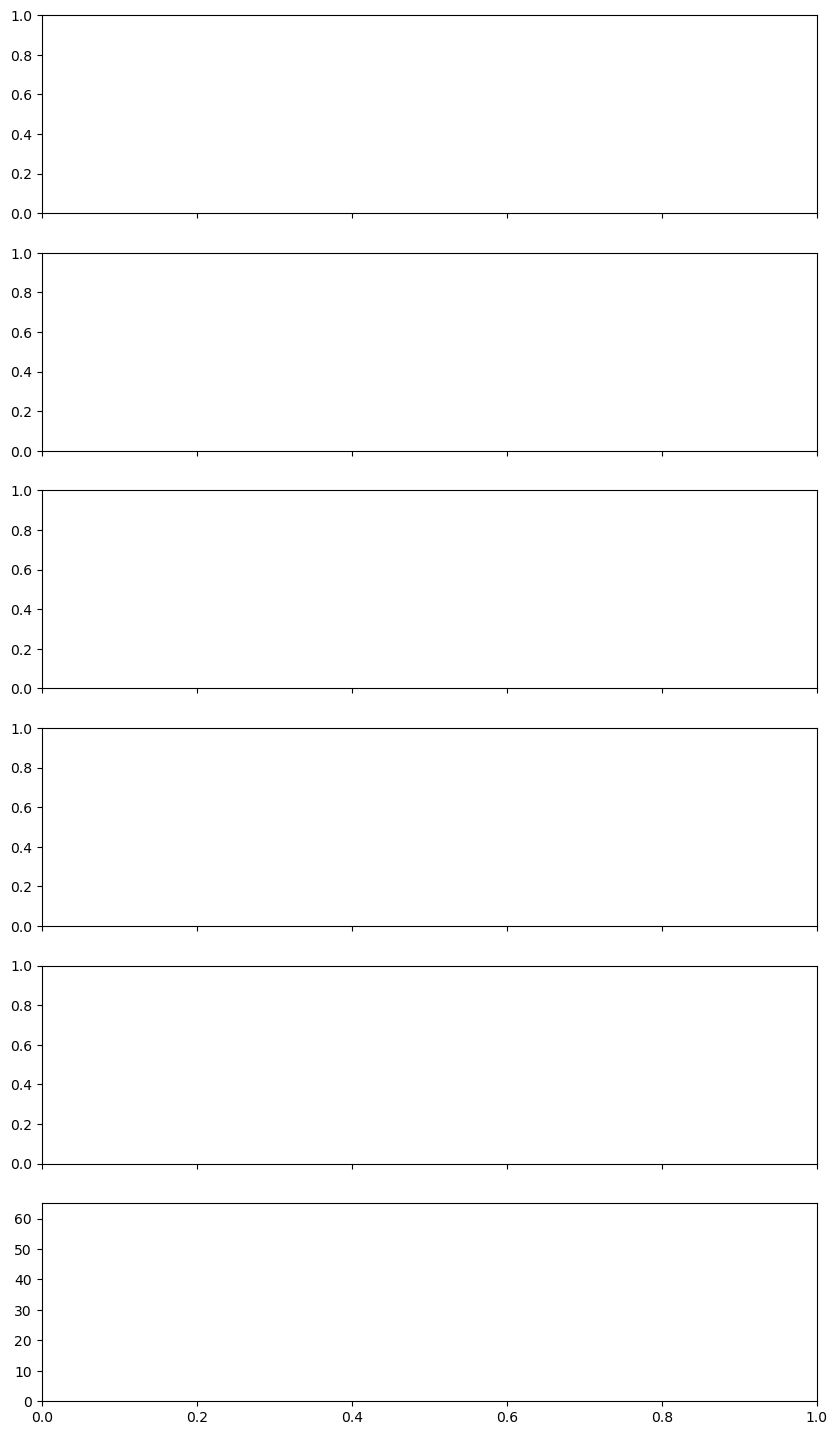

In [15]:
fig, axes = plt.subplots(6, 1, figsize=(10, 18), sharex=True)
plt.ylim(0, 65)

for i in range(6):
    sns.barplot(x=var_logic_clust.index, y=var_logic_clust[i], palette="rocket", ax=axes[i])
    axes[i].axhline(0, color="k", clip_on=False)
    axes[i].set_ylabel(f"Cluster {i}")
    axes[i].bar_label(axes[i].containers[0], fontsize=10)
    axes[i].set_ylim(0, 95)

plt.xticks(rotation=90)
plt.show()

In [72]:
from sklearn.preprocessing import OrdinalEncoder

model_logic = model.logic.model_logic
model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

# 
sort_index = encoded_df.max().sort_values().index